(concepts_advanced)=

# Advanced Concepts

More information regarding the numerical and computational formulation in FLORIS
are detailed here. See [Introductory Concepts](intro_concepts) for a guide on the basics.

In [1]:
# Create a basic FLORIS model for use later
import numpy as np
import matplotlib.pyplot as plt
from floris import FlorisModel
fmodel = FlorisModel("gch.yaml")

## Data structures

FLORIS adopts a structures of arrays data modeling paradigm (SoA, relative to array of structures {AoS})
for nearly all of the data in the `floris.core` package.
This data model enables vectorization (SIMD operations) through Numpy array broadcasting
for many operations.
In general, there are two types of array shapes:
- Field quantities have points throughout the computational domain but in context-specific locations
    and have the shape `(n findex, n turbines, n grid, n grid)`.
- Scalar quantities have a single value for each turbine and typically have the shape
    `(n findex, n turbines, 1, 1)`. For scalar quanities, the arrays
    may be created with the shape `(n findex, n turbines)` and
    then expanded to the 4-dimensional shape prior to running the wake calculation.

## Grids

FLORIS includes a number of grid-types that create sampling points within the computational
domain for different contexts. In the typical use case, AEP or some other metric of wind
farm energy yield is the end result. Since the mathematical models in FLORIS are all
analytical, we only need to create points on the turbines themselves in order to calculate
the incoming wind speeds given all of the upstream conditions. In this case, we use
the {py:meth}`floris.core.grid.TurbineGrid` or {py:meth}`floris.core.grid.TurbineCubatureGrid`.
Each of these grid-types put points only on the turbine swept area, so all other
field-quantities in FLORIS have the same shape.

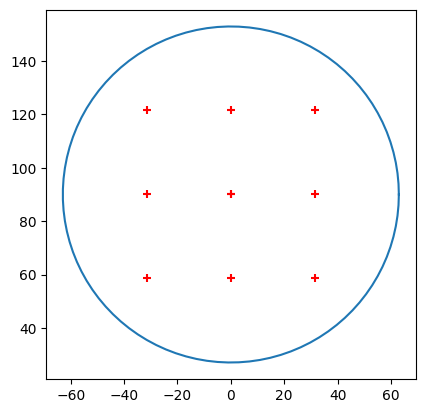

In [2]:
# Plot the grid point locations for TurbineGrid and TurbineCubatureGrid

fmodel.set(layout_x=[0.0], layout_y=[0.0])
rotor_radius = fmodel.core.farm.rotor_diameters[0] / 2.0
hub_height = fmodel.core.farm.hub_heights[0]
theta = np.linspace(0, 2*np.pi, 100)
circlex = rotor_radius * np.cos(theta)
circley = rotor_radius * np.sin(theta) + hub_height

# TurbineGrid is the default
fig, ax = plt.subplots()
ax.scatter(0, hub_height, marker="+", color="r")
ax.scatter(fmodel.core.grid.y_sorted[0,0], fmodel.core.grid.z_sorted[0,0], marker="+", color="r")
ax.plot(circlex, circley)
ax.set_aspect('equal', 'box')
plt.show()

## FLORIS as a library

FLORIS is commonly used as a library in other software packages.
In cases where the calling-code will create inputs for FLORIS rather than require them from the
user, it can be helpful to initialize the FLORIS model with default inputs and then
change them in code.
In this case, the following workflow is recommended.

In [3]:
import floris

# Initialize FLORIS with defaults
fmodel = floris.FlorisModel("defaults")

# Within the calling-code's setup step, update FLORIS as needed
fmodel.set(
    wind_directions=[i for i in range(10)],
    wind_speeds=[5 + i for i in range(10)],
    turbulence_intensities=[i for i in range(10)],
    # turbine_library_path="path/to/turbine_library",   # Shown here for reference
    # turbine_type=["my_turbine"]
)

# Within the calling code's computation, run FLORIS
fmodel.run()

Alternatively, the calling-code can import the FLORIS default inputs as a Python dictionary
and modify them directly before initializing the FLORIS model.
This is especially helpful when the calling-code will modify a parameter that isn't
supported by the `FlorisModel.set(...)` command.
In particular, the wake model parameters are not directly accessible, so these can be updated
externally, as shown below.
Note that the `FlorisModel.get_defaults()` function returns a deep copy of the default inputs,
so these can be modified directly without side effects.

In [4]:
import floris

# Retrieve the default parameters
fdefaults = floris.FlorisModel.get_defaults()

# Update wake model parameters
fdefaults["wake"]["model_strings"]["velocity_model"] = "jensen"
fdefaults["wake"]["wake_velocity_parameters"]["jensen"]["we"] = 0.05

# Initialize FLORIS with modified parameters
fmodel = floris.FlorisModel(configuration=fdefaults)

# Within the calling-code's setup step, update FLORIS as needed
fmodel.set(
    wind_directions=[i for i in range(10)],
    wind_speeds=[5 + i for i in range(10)],
    turbulence_intensities=[i for i in range(10)],
    # turbine_library_path="path/to/turbine_library",   # Shown here for reference
    # turbine_type=["my_turbine"]
)

# Verify settings are correct
fmodel.show_config()  # Shows truncated set of inputs; show all with fmodel.show_config(full=True)

# Within the calling code's computation, run FLORIS
fmodel.run()

solver
    type
        turbine_grid
    turbine_grid_points
        3
wake
    model_strings
        combination_model
            sosfs
        deflection_model
            gauss
        turbulence_model
            crespo_hernandez
        velocity_model
            jensen
farm
    layout_x
        [0.0]
    layout_y
        [0.0]
    turbine_type
        ['nrel_5MW']
    turbine_library_path
        /Users/rmudafor/Development/floris/floris/turbine_library
flow_field
    wind_speeds
        [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
    wind_directions
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    wind_veer
        0.0
    wind_shear
        0.12
    air_density
        1.225
    turbulence_intensities
        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    reference_wind_height
        90.0
name
    GCH
description
    Default initialization: Gauss-Curl hybrid model (GCH)
floris_version
    v4
